<a href="https://colab.research.google.com/github/crispyrinux/Comparing-Explainability-Methods/blob/main/LIME_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm lime scikit-image torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1d5126cb43913a5a1a9301d42fb851c9b998259c0700a248d8e52fc41f628570
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import timm
from skimage.segmentation import slic, mark_boundaries
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
import copy


In [3]:
# Transform untuk CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True)

classes = testset.classes
print("Classes:", classes)


100%|██████████| 170M/170M [10:22<00:00, 274kB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18 pretrained, ubah output ke CIFAR-10
model = timm.create_model("resnet18", pretrained=True, num_classes=10)
model = model.to(device)
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

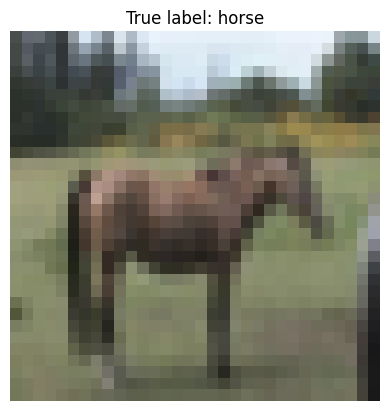

In [5]:
dataiter = iter(testloader)
# Use the image at index 9999
image, label = testset[9999]

# Convert image to numpy and transpose
image = image.numpy().transpose(1, 2, 0)  # (H,W,C)
label = label

plt.imshow((image * 0.5) + 0.5)  # denormalisasi
plt.title(f"True label: {classes[label]}")
plt.axis("off")
plt.show()

In [6]:
def predict_fn(imgs):
    # imgs: list of numpy array (H,W,C), values 0-255
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

    batch = torch.stack([transform(img.astype(np.uint8)) for img in imgs])
    batch = batch.to(device)

    with torch.no_grad():
        outputs = model(batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs


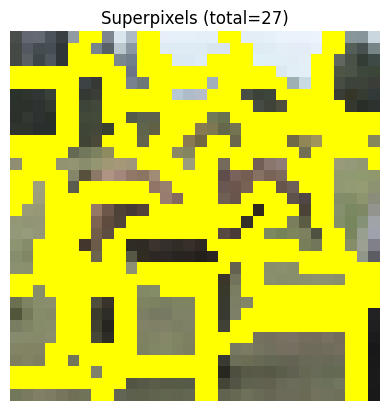

In [7]:
segments = slic((image*255).astype(np.uint8), n_segments=50, compactness=10, sigma=1)
num_superpixels = np.unique(segments).shape[0]

plt.imshow(mark_boundaries((image*0.5+0.5), segments))
plt.title(f"Superpixels (total={num_superpixels})")
plt.axis("off")
plt.show()


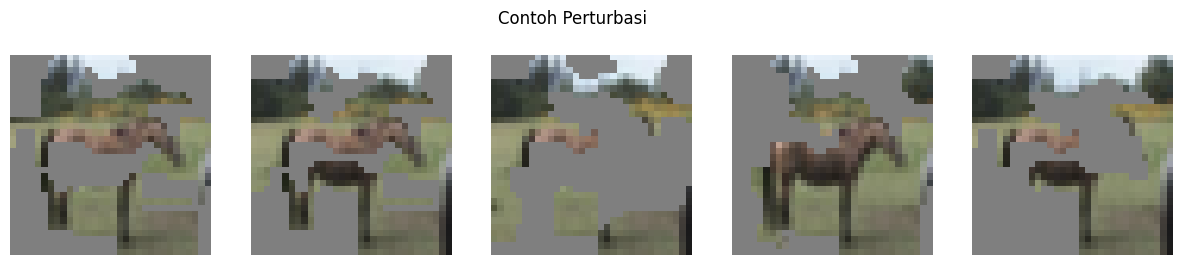

In [8]:
num_perturb = 100
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for a in active_pixels:
        mask[segments == a] = 1
    perturbed = copy.deepcopy(img)
    perturbed = perturbed * mask[:,:,np.newaxis]
    return perturbed

# Contoh beberapa perturbasi
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    pert_img = perturb_image(image, perturbations[i], segments)
    axs[i].imshow((pert_img*0.5+0.5))
    axs[i].axis("off")
plt.suptitle("Contoh Perturbasi")
plt.show()


In [9]:
predictions = []
for pert in perturbations:
    pert_img = perturb_image(image, pert, segments)
    probs = predict_fn([pert_img*255])[0]
    predictions.append(probs)

predictions = np.array(predictions)
predictions.shape


(100, 10)

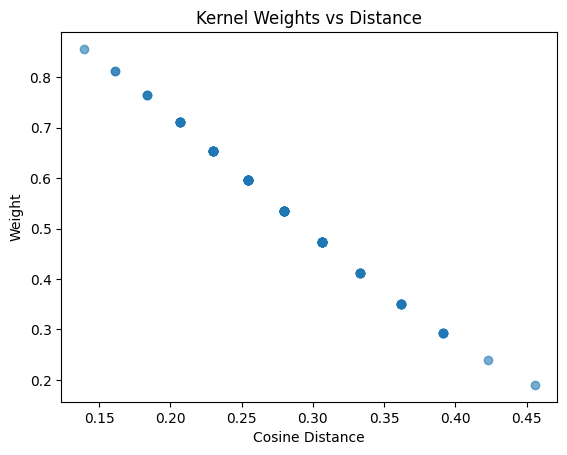

In [10]:
# Perturbasi asli = semua superpixel aktif
original = np.ones(num_superpixels)[np.newaxis, :]
distances = pairwise_distances(perturbations, original, metric='cosine').ravel()

kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))

plt.scatter(distances, weights, alpha=0.6)
plt.xlabel("Cosine Distance")
plt.ylabel("Weight")
plt.title("Kernel Weights vs Distance")
plt.show()


In [11]:
top_class = np.argmax(predict_fn([image*255])[0])

simpler_model = LinearRegression()
simpler_model.fit(X=perturbations,
                  y=predictions[:, top_class],
                  sample_weight=weights)

coeff = simpler_model.coef_


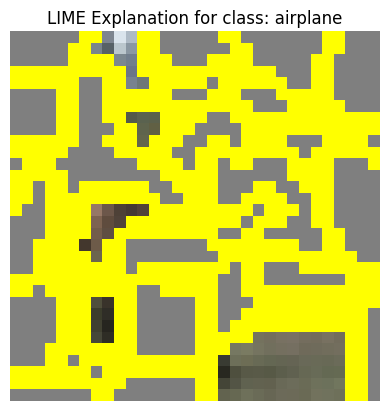

In [12]:
num_top_features = 5
top_features = np.argsort(coeff)[-num_top_features:]

mask = np.zeros(num_superpixels)
mask[top_features] = 1
explanation_img = perturb_image(image, mask, segments)

plt.imshow(mark_boundaries((explanation_img*0.5+0.5), segments))
plt.title(f"LIME Explanation for class: {classes[top_class]}")
plt.axis("off")
plt.show()


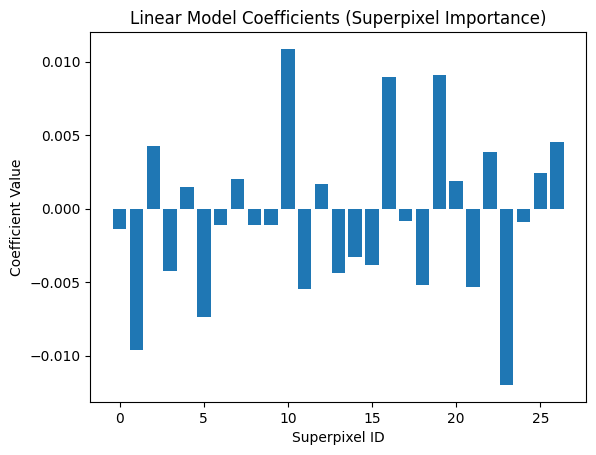

In [13]:
plt.bar(range(len(coeff)), coeff)
plt.title("Linear Model Coefficients (Superpixel Importance)")
plt.xlabel("Superpixel ID")
plt.ylabel("Coefficient Value")
plt.show()
